In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from models import UNet, DiffusionModel
from train_utils import train, evaluate

In [2]:
config = {
    "epoch": 50,
    "batch_size": 64,
    "lr": 8e-5,
    "weight_decay": 1e-4,
    "T": 1000,
    "input_ch": 1,
    "channel": 64,
    "channel_mult": [1,2,3],
    "attn": [1,2],
    "num_res_blocks": 2,
    "dropout": 0.1,
    "beta_range": (1e-4, 0.02),
    "device": "cuda:0",
}

扩散过程
$$q(x_t|x_{t-1})=\mathcal{N}(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_t I)$$
变量代换
$$\alpha_t=1-\beta_t$$
$$\bar{\alpha_t}=\Pi_{i=1}^t \alpha_i$$
可得
$$q(x_t|x_0)=\mathcal{N}(x_t;\sqrt{\bar{\alpha_t}}x_0,(1-\bar{\alpha_t})I)$$

逆扩散过程
$$q(x_{t-1}|x_t,x_0)=\mathcal{N}(x_{t-1};\tilde{\mu}(x_t,x_0),\tilde{\beta_t} I)$$
其中
$$\tilde{\mu_t}=\tilde{\mu}(x_t,x_0)=\frac{1}{\sqrt{\alpha_t}}(x_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha_t}}}z_t)$$

In [3]:
betas = torch.linspace(start=config['beta_range'][0],
                       end=config['beta_range'][1],
                       steps=config['T'])
alphas = 1 - betas

In [4]:
alphas_bar = torch.cumprod(alphas, dim=0)

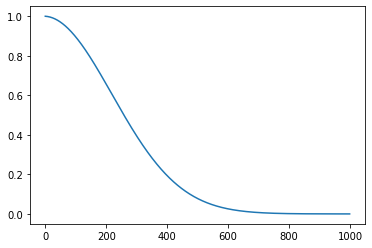

In [5]:
plt.plot(alphas_bar)

In [6]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5),
])

mnist_train = torchvision.datasets.MNIST(
    root="./data/",
    train=True,
    download=True,
    transform=transform,
)

mnist_eval = torchvision.datasets.MNIST(
    root="./data/",
    train=False,
    download=True,
    transform=transform,
)

In [7]:
device = torch.device(config["device"])
print("device:",device)
model = UNet(
T=config["T"], input_ch=config["input_ch"], ch=config["channel"], ch_mult=config["channel_mult"], attn=config["attn"],
num_res_blocks=config["num_res_blocks"], dropout=config["dropout"]).to(device)
# x = torch.randn(config["batch_size"], 3, 28, 28)
# t = torch.randint(config["T"], (config["batch_size"], ))
# y = model(x, t)
# print(y.shape)
# assert x.shape == y.shape

device: cuda:0


In [8]:
# num of unet parameters
sum(p.numel() for p in model.parameters())

10791425

In [9]:
diffusion_model = DiffusionModel(model=model,beta_range=config["beta_range"],T=config["T"]).to(device)

In [10]:
sum(p.numel() for p in diffusion_model.parameters())

10791425

In [11]:
optimizer = torch.optim.AdamW(diffusion_model.parameters(),lr=config["lr"],weight_decay=config["weight_decay"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=config["epoch"])

In [12]:
train_dataloader = DataLoader(mnist_train, batch_size=config["batch_size"], shuffle=True,)
eval_dataloader = DataLoader(mnist_eval, batch_size=config["batch_size"])

In [ ]:
for epoch in range(config["epoch"]):
    print("epoch:",epoch+1)
    train(diffusion_model=diffusion_model, dataloader=train_dataloader, optimizer=optimizer, scheduler=scheduler ,verbose=True)
    evaluate(diffusion_model=diffusion_model, dataloader=eval_dataloader)
    if epoch%10 == 9:
        print("saving model in epoch", epoch+1)
        file_name = "./checkpoints/mnist_epoch"+str(epoch+1)+".pth"
        torch.save(diffusion_model.state_dict(), file_name)
        print("saved to ", file_name)

epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]

step: 100  training loss=0.7325
step: 200  training loss=0.2331
step: 300  training loss=0.0792
step: 400  training loss=0.0502
step: 500  training loss=0.0443
step: 600  training loss=0.0414
step: 700  training loss=0.0393
step: 800  training loss=0.0369
step: 900  training loss=0.0378


  0%|          | 0/157 [00:00<?, ?it/s]

eval loss=0.0333
epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]

step: 100  training loss=0.0376
step: 200  training loss=0.0365
step: 300  training loss=0.0344
step: 400  training loss=0.0352
step: 500  training loss=0.0336
step: 600  training loss=0.0331
step: 700  training loss=0.0325
step: 800  training loss=0.0322
step: 900  training loss=0.0322


  0%|          | 0/157 [00:00<?, ?it/s]

eval loss=0.0299
epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]

step: 100  training loss=0.0316
step: 200  training loss=0.0321
step: 300  training loss=0.0310
step: 400  training loss=0.0305
step: 500  training loss=0.0316
step: 600  training loss=0.0312
step: 700  training loss=0.0309
step: 800  training loss=0.0309
step: 900  training loss=0.0303


  0%|          | 0/157 [00:00<?, ?it/s]

eval loss=0.0286
epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]

step: 100  training loss=0.0305
step: 200  training loss=0.0301
step: 300  training loss=0.0289
step: 400  training loss=0.0292
step: 500  training loss=0.0292
step: 600  training loss=0.0293
step: 700  training loss=0.0287
step: 800  training loss=0.0286
step: 900  training loss=0.0290


  0%|          | 0/157 [00:00<?, ?it/s]

eval loss=0.0258
epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]

step: 100  training loss=0.0286
step: 200  training loss=0.0288
step: 300  training loss=0.0285
step: 400  training loss=0.0265
step: 500  training loss=0.0275
step: 600  training loss=0.0279
step: 700  training loss=0.0283
step: 800  training loss=0.0266
step: 900  training loss=0.0270


  0%|          | 0/157 [00:00<?, ?it/s]

eval loss=0.0264
epoch: 6


  0%|          | 0/938 [00:00<?, ?it/s]

step: 100  training loss=0.0278
step: 200  training loss=0.0279
step: 300  training loss=0.0274
step: 400  training loss=0.0276
step: 500  training loss=0.0279
step: 600  training loss=0.0266
step: 700  training loss=0.0267
step: 800  training loss=0.0271
step: 900  training loss=0.0275


  0%|          | 0/157 [00:00<?, ?it/s]

eval loss=0.0255
epoch: 7


  0%|          | 0/938 [00:00<?, ?it/s]

step: 100  training loss=0.0262
step: 200  training loss=0.0273
step: 300  training loss=0.0270
step: 400  training loss=0.0274
step: 500  training loss=0.0277
step: 600  training loss=0.0260
step: 700  training loss=0.0273
step: 800  training loss=0.0262
step: 900  training loss=0.0268


  0%|          | 0/157 [00:00<?, ?it/s]

eval loss=0.0244
epoch: 8


  0%|          | 0/938 [00:00<?, ?it/s]

step: 100  training loss=0.0262
step: 200  training loss=0.0262
step: 300  training loss=0.0259
step: 400  training loss=0.0257
step: 500  training loss=0.0256
step: 600  training loss=0.0262
step: 700  training loss=0.0265
step: 800  training loss=0.0261
step: 900  training loss=0.0261


  0%|          | 0/157 [00:00<?, ?it/s]

eval loss=0.0251
epoch: 9


  0%|          | 0/938 [00:00<?, ?it/s]

step: 100  training loss=0.0264
step: 200  training loss=0.0259
step: 300  training loss=0.0253
step: 400  training loss=0.0249
step: 500  training loss=0.0249


In [35]:
torch.save(diffusion_model.state_dict(), "./checkpoints/mnist10epoch.pth")

In [11]:
diffusion_model.load_state_dict(torch.load("./checkpoints/mnist_epoch50.pth"))

<All keys matched successfully>

In [30]:
noisyImage = torch.randn(
    size=[16, 1, 28, 28], device=device)

In [31]:
sampled_img, hiddens = diffusion_model.sample(noisyImage, verbose=True, return_hiddens=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [32]:
sampled_img.shape

torch.Size([16, 1, 28, 28])

In [33]:
sampled_img = sampled_img * 0.5 + 0.5  # [0 ~ 1]

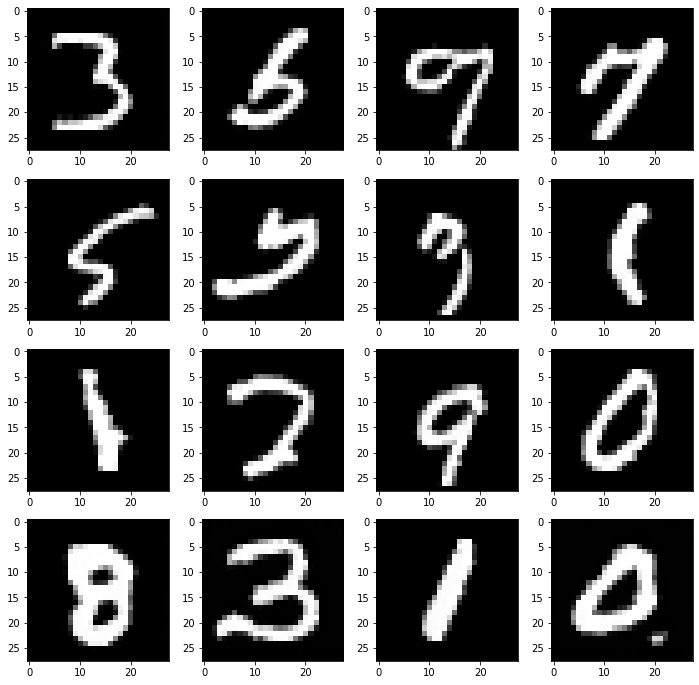

In [34]:
plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(sampled_img[i].squeeze(0).cpu().numpy(), cmap="gray")

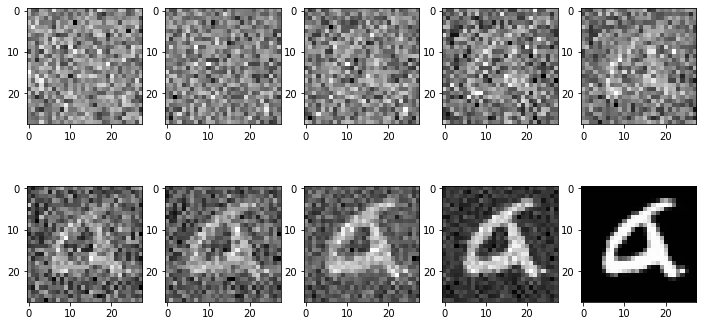

In [21]:
plt.figure(figsize=(12,6))
for i,time in enumerate([0,100,150,200,250,300,350,400,450,499]):
    plt.subplot(2,5,i+1)
    img = hiddens[time][5] * 0.5 + 0.5
    plt.imshow(img.squeeze(0).cpu().numpy(), cmap="gray")